In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from typing import List, Callable
from scipy import stats
import timeit
import copy
import os
import Hawkes as hk
from datetime import datetime as dt
import warnings
import collections.abc
from tqdm import tqdm
import os.path as osp

In [3]:
register_matplotlib_converters()
sns.set()
warnings.filterwarnings("ignore")

# Loading of the trading data.

In [51]:
# list the files in the directory
data_files_list = os.listdir("Data/RENA.PA/")
data_files_list = [f for f in data_files_list if "trades" in f]
# import each day as a pandas DF in a dictionary
data_dict = {i : pd.read_csv("Data/RENA.PA/"+f, index_col = 0) for i,f in zip(range(len(data_files_list)),data_files_list) }

The first and last observations are filtered as they are influenced by the opening and closing auction.

In [52]:
for key, df in data_dict.items():
    df['ts'] = pd.to_datetime(df["ts"])
    initial_time = df.iloc[0,0]
    date = initial_time.strftime('%Y-%m-%d')
    upper_bound = pd.Timestamp(date + ' 17:00:00')
    lower_bound = pd.Timestamp(date + ' 09:30:00')
    df = df[(df['ts'] > lower_bound) & (df['ts'] < upper_bound)]
    data_dict[key] = df

In [53]:
data_dict[0].head(10)

,ts,price,volume
96,2017-01-02 09:30:34.211,84.50,10
97,2017-01-02 09:30:34.211,84.50,100
98,2017-01-02 09:30:34.211,84.50,25
99,2017-01-02 09:30:34.211,84.50,25
100,2017-01-02 09:31:03.210,84.48,15
101,2017-01-02 09:31:14.159,84.54,144
102,2017-01-02 09:32:52.542,84.60,175
103,2017-01-02 09:32:52.542,84.61,35
104,2017-01-02 09:32:52.542,84.61,70
105,2017-01-02 09:32:52.893,84.64,59


# 1\ Visual inspection.

A sample of the trading data is selected.

In [54]:
df_t = data_dict[0]

The event times are computed, with the convention that only one event happens at a given time. There is indeed a choice to make since the precision of the data is the millisecond, and in prcatice several orders can be sent in a millisecond.

In [56]:
initial_time = df_t.iloc[0,0]
df_t['diff'] = df_t['ts'] - initial_time
df_t['events'] = df_t['diff'].dt.total_seconds()
df_t = df_t.drop_duplicates(subset=['events'])
T_i = df_t['events'].values

## Fit

In [ ]:
model = hk.estimator()
model.set_kernel('exp', num_exp = 1)
model.set_baseline('const')
itv = [T_i[0], T_i[20]] # the observation interval
model.fit(T_i[:20],itv) # T is the event times (numpy.ndarray)

In [65]:
print("parameters:",model.parameter) # the estimated parameter values
print("branching ratio:",model.br) # the branching ratio
print("log-likelihood:",model.L) # the log-likelihood of the estimated parameter values
print("AIC:",model.AIC) # the AIC of the estimated parameter values

parameters: {'mu': 0.2583240131505166, 'alpha': 0.11752517074693501, 'beta': 1.6633454540694648}
branching ratio: 0.11752517074693501
log-likelihood: -42.0330828495605
AIC: 90.066165699121


## Test of fit.

If the estimated model is correct, the transformed event occurrence times, given as $\{t'_i = \int_0^{t_i}\lambda(t|H_t)dt\}$, are uniformly distributed in the interval $[0,\int_0^{l}\lambda(t|H_t)dt]$ ($l$ is the length of the observation interval). This property enables us to validate the estimated model.


In [66]:
# T_trans: a list of transformed event occurrence times, itv_trans: the transformed observation interval
[T_trans, itv_trans] = model.t_trans() 
T_trans = list(map(lambda z: z / itv_trans[-1], T_trans))
statisitc, p_value = stats.kstest(T_trans, 'uniform')

In [67]:
print("KS statistic:",statisitc)
print("KS p-value:", p_value)

KS statistic: 0.2514487532344587
KS p-value: 0.15174899728042812


The p-value is high which means one do not reject $H_0$ that says that the fit is good. 

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

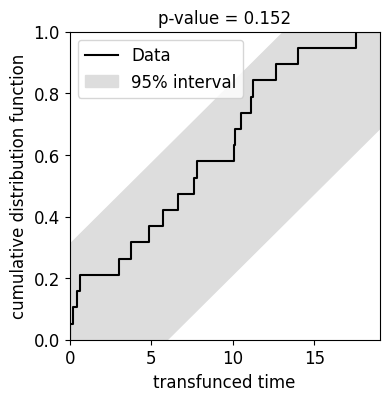

In [68]:
# Kormogorov-Smirnov test under the null hypothesis that the transformed event occurrence times are uniformly distributed
model.plot_KS() 

Faire tendre T vers l'infini et voir les estimateurs convergent bien sur les plusieurs jours etudiés

## 1.2\ Let us try to increase the sample size and see whether it converges.

In [69]:
def compute_event_times(df: pd.DataFrame) -> List[float]:
    # take the required sample that is specified by num_hours:
    initial_time = df.iloc[0,0]
    date = initial_time.strftime('%Y-%m-%d')
    df['diff'] = df['ts'] - initial_time
    df['events'] = df['diff'].dt.total_seconds()
    df = df.drop_duplicates(subset=['events'])
    T_i = df['events'].values

    return T_i

In [70]:
T_i_all_daily = [compute_event_times(e) for _, e in data_dict.items()]

In [71]:
max_i = []
for T_i in T_i_all_daily:
    max_i.append(np.max(T_i))

In [76]:
T = np.linspace(50, np.max(max_i), num = 5)
T = [int(t) for t in T]
keys = ['lbd_0', 'alpha', 'beta']
num_sample = len(T_i_all_daily)

dfs = []

for T_max in tqdm(T):

    df_dict = {key : [] for key in keys}

    for T_i in T_i_all_daily: # ie for each day

        # retrieve the process until T_max
        process_realization = [e for e in T_i if e < T_max]

        # estimate the parameters
        estimator = hk.estimator()
        estimator.set_kernel('exp',num_exp=1)
        estimator.set_baseline('const')
        estimates = list(estimator.fit(process_realization,[0,T_max]).parameter.values())


        
        for i, key in enumerate(keys):
            df_dict[key].append(estimates[i])


    df_i = pd.DataFrame.from_dict(df_dict).assign(T=T_max)
    dfs.append(df_i)

100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


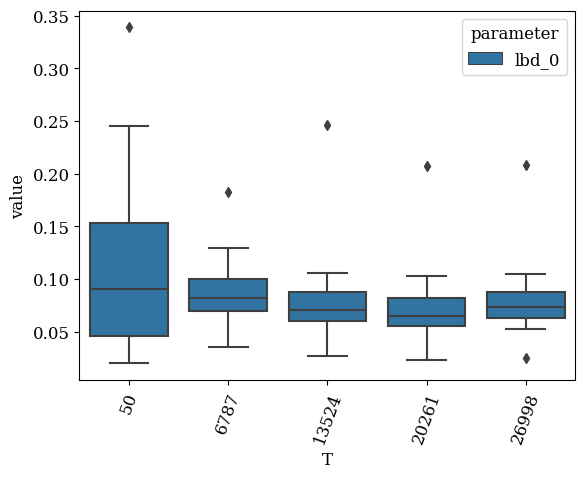

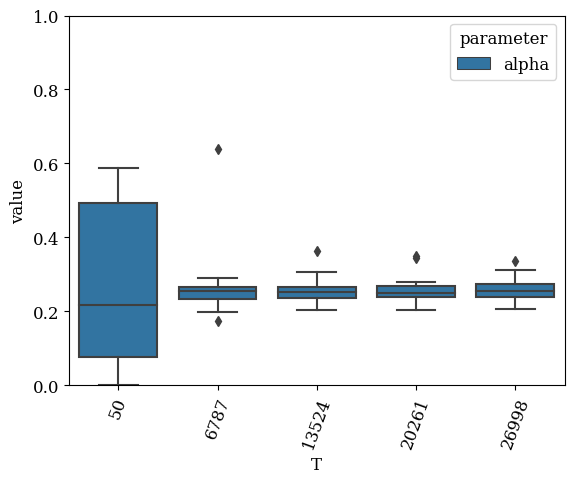

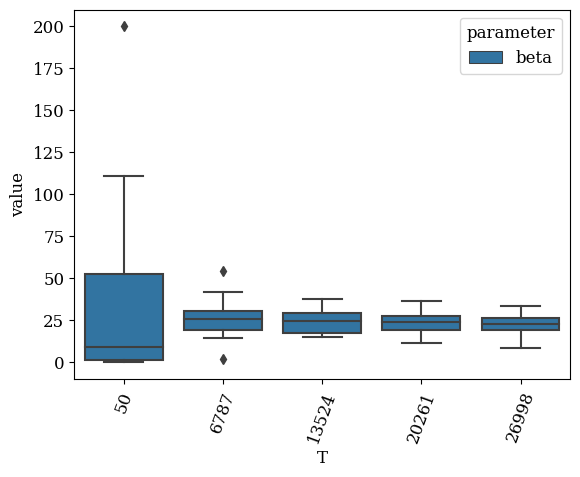

In [85]:
cdf = pd.concat(dfs)
mdf = pd.melt(cdf, id_vars=['T'], var_name=['parameter'])
for i, key in enumerate(keys):
    ax = sns.boxplot(x="T", y="value", hue="parameter", data=mdf[mdf['parameter'] == key])  
    plt.xticks(rotation=70)
    if i == 1:
        plt.ylim(top = 1, bottom = 0)
    plt.show()
    plt.clf()
    plt.close()

After removal of some outliers it seems that the longer the period, the better the estimator. However there is still a lot of variance, especially for beta. Perhaps in the many models that will be fit in the next part some will have a better fit. This will be measured via log-likelihoond or AIC.

# 2\ Systematic analysis.

In [147]:
def estimate_parameters(df_daily: pd.DataFrame, baseline_class: str, kernel_class: str, num_kernels: int, num_hours: int, save_name: str, num_basis: int = 10, plot: bool = False) -> None:
    
    # take the required sample that is specified by num_hours:
    initial_time = df_daily.iloc[0,0]
    date = initial_time.strftime('%Y-%m-%d')
    if num_hours < 1:
        if num_hours == .25:
            upper_bound = pd.Timestamp(date + ' 09:45:00')
        elif num_hours == .5:
            upper_bound = pd.Timestamp(date + ' 10:00:00')
        else:
            raise ValueError('The value for num_hours should be .25 or .5 if it is lower that 1.')
    else:
        upper_bound = pd.Timestamp(date + ' ' + str(9 + num_hours) + ':30:00')

    df = df_daily[df_daily['ts'] < upper_bound].copy()

    df['diff'] = df['ts'] - initial_time
    df['events'] = df['diff'].dt.total_seconds()
    df = df.drop_duplicates(subset=['events'])
    T_i = df['events'].values

    # model init
    model = hk.estimator()
    model.set_kernel(kernel_class, num_exp = num_kernels)
    if baseline_class == 'const':
        model.set_baseline(baseline_class)
    else:
        model.set_baseline(baseline_class, num_basis = num_basis)
    itv = [T_i[0], T_i[-1]] # the observation interval

    # fit
    model.fit(T_i, itv) # T is the event times (numpy.ndarray)
    print("parameters:",model.parameter) # the estimated parameter values
    print("branching ratio:",model.br) # the branching ratio
    print("log-likelihood:",model.L) # the log-likelihood of the estimated parameter values
    print("AIC:",model.AIC) # the AIC of the estimated parameter values
    
    # goodness of fit
    [T_trans, itv_trans] = model.t_trans() 
    T_trans = list(map(lambda z: z / itv_trans[-1], T_trans))
    ks_stat, p_value = stats.kstest(T_trans, 'uniform')
    print("KS statistic:",ks_stat)
    print("KS p-value:", p_value)
    # Kormogorov-Smirnov test under the null hypothesis that the transformed event occurrence times are uniformly distributed
    if plot:
        model.plot_KS() 
        plt.savefig(save_name)

    # store the parameters
    out = model.parameter
    if not isinstance(out['mu'], collections.abc.Sequence):
        out['mu'] = np.ones(shape = (num_basis,)) * out['mu']
    
    # store the score
    out['ks_stat'] = ks_stat
    out['p_value'] = p_value
    out['aic'] = model.AIC
    out['lg_likelihood'] = model.L
    out['branching_ratio'] = model.br

    print()

    return out

    


In [148]:
dfs_daily = [e for _, e in data_dict.items()]
baseline_classes = ['const', 'plinear']
kernel_classes = ['exp']
nums_kernels = [1, 2, 4, 6, 8]
nums_hours = [.25, .5, 1., 2., 4., 8.]

num_basis = 10

In [149]:
parameters_names = ['alpha', 'beta'] + ['mu_' + str(i) for i in range(num_basis)]
col_names = ['date', 'baseline_class', 'num_basis', 'kernel_class', 'num_kernels', 'num_hours'] + parameters_names + ['ks_stat', 'p_value', 'lg_likelihood', 'aic', 'branching_ratio'] 
dict_for_df = {parameter: [] for parameter in col_names}

In [151]:
def loop():
    for df_daily in tqdm(dfs_daily):
        for baseline_class in baseline_classes:
            for kernel_class in kernel_classes:
                for num_kernels in nums_kernels:
                    for num_hours in nums_hours:
        
                        date = str(df_daily.iloc[0,0])[:10]
                        out = estimate_parameters(df_daily, 
                                                    baseline_class, 
                                                    kernel_class, 
                                                    num_kernels, 
                                                    num_hours, 
                                                    osp.join('./figs', date + '.png'), 
                                                    num_basis, 
                                                    plot = False)

                        # store the estimated parameters
                        for col in parameters_names:
                            if not col.startswith('mu'):
                                dict_for_df[col].append(out[col])
                        for i in range(num_basis):
                                dict_for_df['mu_' + str(i)].append(out['mu'][i])
                        
                        # store the caracteristics of the fit
                        dict_for_df['date'].append(date)
                        dict_for_df['baseline_class'].append(baseline_class)
                        dict_for_df['num_basis'].append(num_basis)
                        dict_for_df['kernel_class'].append(kernel_class)
                        dict_for_df['num_kernels'].append(num_kernels)
                        dict_for_df['num_hours'].append(num_hours)

                        # store the score of the fit
                        dict_for_df['ks_stat'].append(out['ks_stat'])
                        dict_for_df['p_value'].append(out['p_value'])
                        dict_for_df['aic'].append(out['aic'])
                        dict_for_df['lg_likelihood'].append(out['lg_likelihood'])
                        dict_for_df['branching_ratio'].append(out['branching_ratio'])

    df_parameters = pd.DataFrame.from_dict(dict_for_df)
    df_parameters.to_csv('./results.csv')        

In [152]:
loop()

  0%|          | 0/22 [00:00<?, ?it/s]

parameters: {'mu': 0.025236495156404713, 'alpha': 0.16338587666577448, 'beta': 2.858403120144854}
branching ratio: 0.16338587666577448
log-likelihood: -111.13295481565618
AIC: 228.26590963131235
KS statistic: 0.14845495843803286
KS p-value: 0.5651264274275618

parameters: {'mu': 0.050363665044731054, 'alpha': 0.29823958182529736, 'beta': 22.85804340513167}
branching ratio: 0.29823958182529736
log-likelihood: -334.224723232138
AIC: 674.449446464276
KS statistic: 0.20012749450312503
KS p-value: 6.71704704022571e-05

parameters: {'mu': 0.04612771216942539, 'alpha': 0.31427562054380687, 'beta': 23.11282745050147}
branching ratio: 0.31427562054380687
log-likelihood: -625.9260808733974
AIC: 1257.8521617467948
KS statistic: 0.10157166457715805
KS p-value: 0.01425140850318007

parameters: {'mu': 0.03405118626596136, 'alpha': 0.2856467338552101, 'beta': 27.059945229410044}
branching ratio: 0.2856467338552101
log-likelihood: -1027.410466694162
AIC: 2060.820933388324
KS statistic: 0.1649673044768

  5%|▍         | 1/22 [00:06<02:06,  6.04s/it]

parameters: {'mu': array([0.03239676, 0.01876648, 0.01380528, 0.01393676, 0.01237248,
       0.00422584, 0.01061531, 0.01400252, 0.02347921, 0.01614485]), 'alpha': array([1.57269637e-02, 9.66088116e-02, 4.29779924e-04, 2.51666755e-02,
       1.57635501e-04, 7.11483462e-02, 1.70409309e-01, 1.82905930e-01]), 'beta': array([1.46996073e+00, 1.44455170e-01, 5.26959415e+01, 1.46996091e+00,
       1.06747107e+01, 1.06747182e+01, 3.29977539e-03, 5.26959439e+01])}
branching ratio: 0.562553451774991
log-likelihood: -2953.749936518101
AIC: 5913.499873036202
KS statistic: 0.02892360302164726
KS p-value: 0.41835276890197004

parameters: {'mu': 0.16962276330156678, 'alpha': 0.4128809729926045, 'beta': 32.43736610236287}
branching ratio: 0.4128809729926045
log-likelihood: -297.5896546201303
AIC: 601.1793092402606
KS statistic: 0.11975475722026996
KS p-value: 0.0013958968587341174

parameters: {'mu': 0.14911933972340882, 'alpha': 0.3371501041110017, 'beta': 31.41910792324813}
branching ratio: 0.337150

  9%|▉         | 2/22 [00:23<04:12, 12.63s/it]

parameters: {'mu': array([0.10693048, 0.0985234 , 0.07594001, 0.0525477 , 0.03452262,
       0.03631424, 0.03716178, 0.07095169, 0.04396193, 0.05952211]), 'alpha': array([5.33519426e-02, 5.44251833e-04, 1.49765315e-04, 1.28076909e-03,
       4.08925637e-02, 5.57230724e-02, 1.49208223e-01, 1.52714599e-01]), 'beta': array([ 0.5812646 ,  0.58126428,  9.77570583,  9.77575549,  9.77576062,
        9.77576051,  0.07766132, 59.69402653])}
branching ratio: 0.4538651866206735
log-likelihood: -7200.793904585142
AIC: 14407.587809170283
KS statistic: 0.018939127368337742
KS p-value: 0.2414652305909798

parameters: {'mu': 0.0835632319425717, 'alpha': 0.25686288664593593, 'beta': 70.0618275489151}
branching ratio: 0.25686288664593593
log-likelihood: -228.21894755656913
AIC: 462.43789511313827
KS statistic: 0.11749028006378048
KS p-value: 0.11990299429472076

parameters: {'mu': 0.09498117625138537, 'alpha': 0.23919559124810033, 'beta': 48.89374572067142}
branching ratio: 0.23919559124810033
log-likel

 14%|█▎        | 3/22 [00:39<04:27, 14.10s/it]

parameters: {'mu': array([0.06838592, 0.06095861, 0.04052924, 0.02566555, 0.03470443,
       0.02898888, 0.0253612 , 0.03407642, 0.08985027, 0.07421779]), 'alpha': array([0.08371206, 0.0036539 , 0.00334419, 0.05198869, 0.01710413,
       0.03149012, 0.07609318, 0.16629558]), 'beta': array([ 0.06532355,  1.13621198,  9.49079792,  9.49079782,  9.49079788,
        0.73583187,  0.20829179, 63.72401108])}
branching ratio: 0.43368183512192165
log-likelihood: -5831.698835831243
AIC: 11669.397671662486
KS statistic: 0.01305481900235328
KS p-value: 0.8471148370031127

parameters: {'mu': 0.15131928049488907, 'alpha': 0.3136333214213809, 'beta': 17.01259474249515}
branching ratio: 0.3136333214213809
log-likelihood: -372.47492629919054
AIC: 750.9498525983811
KS statistic: 0.19396585838446406
KS p-value: 5.321855698578477e-07

parameters: {'mu': 0.14319733933829384, 'alpha': 0.2622980323700659, 'beta': 34.87602989895695}
branching ratio: 0.2622980323700659
log-likelihood: -684.240366221004
AIC: 137

 18%|█▊        | 4/22 [01:00<05:06, 17.05s/it]

parameters: {'mu': array([0.11239498, 0.09017788, 0.08769544, 0.07004527, 0.05527152,
       0.06243718, 0.06883898, 0.10935283, 0.09617295, 0.10824827]), 'alpha': array([0.07659318, 0.02876332, 0.05208137, 0.00293696, 0.06960358,
       0.02162145, 0.02727649, 0.12631412]), 'beta': array([1.69571641e-02, 3.28957324e+00, 3.28957312e+00, 3.28957341e+00,
       3.28957335e+00, 5.84774906e+01, 3.43306546e-01, 5.84774919e+01])}
branching ratio: 0.405190478638661
log-likelihood: -8969.754997424363
AIC: 17945.509994848726
KS statistic: 0.010541038418489565
KS p-value: 0.7906916966367808

parameters: {'mu': 0.04657928957170162, 'alpha': 0.20293730419208975, 'beta': 72.6142047723919}
branching ratio: 0.20293730419208975
log-likelihood: -151.209410999307
AIC: 308.418821998614
KS statistic: 0.12633216190894336
KS p-value: 0.3826910091201755

parameters: {'mu': 0.054121208169177315, 'alpha': 0.2691748843182922, 'beta': 23.32988773115676}
branching ratio: 0.2691748843182922
log-likelihood: -361.95

 23%|██▎       | 5/22 [01:23<05:22, 18.98s/it]

parameters: {'mu': array([0.03210009, 0.0350791 , 0.03534211, 0.0283821 , 0.02002128,
       0.01876056, 0.02629813, 0.04433612, 0.04704661, 0.05479411]), 'alpha': array([0.04815274, 0.00249385, 0.00047804, 0.03829879, 0.03211267,
       0.08515078, 0.19993355, 0.14373456]), 'beta': array([8.41158635e-01, 8.41158123e-01, 8.41158925e-01, 2.45778515e-01,
       2.45778364e-01, 9.48033660e+00, 1.48971514e-02, 6.10936955e+01])}
branching ratio: 0.5503549918221532
log-likelihood: -5596.44113236593
AIC: 11198.88226473186
KS statistic: 0.016593273431196653
KS p-value: 0.6386667013229745

parameters: {'mu': 0.11397875012252155, 'alpha': 0.23293949976371578, 'beta': 35.15530755259877}
branching ratio: 0.23293949976371578
log-likelihood: -304.44140959059337
AIC: 614.8828191811867
KS statistic: 0.12171094599950183
KS p-value: 0.03779052530524176

parameters: {'mu': 0.10574736855115165, 'alpha': 0.25615650918506544, 'beta': 27.64520765760712}
branching ratio: 0.25615650918506544
log-likelihood: -5

 27%|██▋       | 6/22 [01:40<04:56, 18.53s/it]

parameters: {'mu': array([0.0720845 , 0.0526618 , 0.07749955, 0.04444954, 0.03070464,
       0.0344935 , 0.04535742, 0.06698928, 0.07523892, 0.06707753]), 'alpha': array([0.13679094, 0.05445893, 0.01380197, 0.00122884, 0.02798523,
       0.06624269, 0.08331696, 0.16145207]), 'beta': array([2.47116017e-01, 4.98068205e-02, 2.47116357e-01, 7.02096814e+00,
       7.02095637e+00, 7.02095566e+00, 6.53847543e-03, 6.06559911e+01])}
branching ratio: 0.5452776385084868
log-likelihood: -7784.769662524164
AIC: 15575.539325048328
KS statistic: 0.012485326762076088
KS p-value: 0.6837641335984712

parameters: {'mu': 0.08294333041556048, 'alpha': 0.4039503530890008, 'beta': 7.646807282387483}
branching ratio: 0.4039503530890008
log-likelihood: -262.57858082781365
AIC: 531.1571616556273
KS statistic: 0.0901005769774102
KS p-value: 0.2634878008123013

parameters: {'mu': 0.09824659317379632, 'alpha': 0.32965899439894003, 'beta': 9.584717374786004}
branching ratio: 0.32965899439894003
log-likelihood: -605

 32%|███▏      | 7/22 [01:56<04:26, 17.75s/it]

parameters: {'mu': array([0.04428942, 0.04742832, 0.03525756, 0.02824492, 0.02703304,
       0.02166253, 0.03633554, 0.0341951 , 0.1208551 , 0.11222821]), 'alpha': array([0.01235079, 0.02667733, 0.18679535, 0.0848063 , 0.07117384,
       0.04181791, 0.08479147, 0.15409908]), 'beta': array([1.06615106e-02, 2.49517772e-01, 1.06615103e-02, 2.49517833e-01,
       5.09316978e+00, 1.20196253e+00, 5.14275816e-02, 6.60049067e+01])}
branching ratio: 0.6625120814530493
log-likelihood: -8251.864655361811
AIC: 16509.729310723622
KS statistic: 0.021243742544121424
KS p-value: 0.0652005581697247

parameters: {'mu': 0.07963444233405055, 'alpha': 0.2606669840492595, 'beta': 36.748737496772385}
branching ratio: 0.2606669840492595
log-likelihood: -228.8317239041674
AIC: 463.6634478083348
KS statistic: 0.05778129308807345
KS p-value: 0.8975116539289715

parameters: {'mu': 0.08157990981312524, 'alpha': 0.2996962223416838, 'beta': 15.495125561947853}
branching ratio: 0.2996962223416838
log-likelihood: -503

 36%|███▋      | 8/22 [02:11<03:55, 16.85s/it]

parameters: {'mu': array([0.05563872, 0.09959387, 0.08264794, 0.07054393, 0.03231344,
       0.07894549, 0.05664978, 0.05139901, 0.07466583, 0.07274651]), 'alpha': array([0.00633174, 0.03501808, 0.0272746 , 0.01625803, 0.00848063,
       0.08424423, 0.04951208, 0.17385686]), 'beta': array([ 1.34780571,  8.1737061 , 55.65751823,  8.17370517,  8.17370508,
        0.0707198 ,  1.34780572, 55.6575194 ])}
branching ratio: 0.40097624693440187
log-likelihood: -7261.390287959475
AIC: 14528.78057591895
KS statistic: 0.012855516056041294
KS p-value: 0.6880101614147986

parameters: {'mu': 0.11068834206184865, 'alpha': 0.2906938442810428, 'beta': 35.728429018869164}
branching ratio: 0.2906938442810428
log-likelihood: -279.2091439765241
AIC: 564.4182879530482
KS statistic: 0.07144528589104615
KS p-value: 0.4697452990181965

parameters: {'mu': 0.09001593197731694, 'alpha': 0.26885064864885394, 'beta': 42.38519739043729}
branching ratio: 0.26885064864885394
log-likelihood: -489.6265048843047
AIC: 985

 41%|████      | 9/22 [02:25<03:24, 15.74s/it]

parameters: {'mu': array([0.06550225, 0.0295837 , 0.05532004, 0.03703712, 0.03249422,
       0.02745821, 0.03474688, 0.03594363, 0.05407769, 0.06452757]), 'alpha': array([0.18249838, 0.00258755, 0.00259002, 0.00686903, 0.01166621,
       0.05703345, 0.12379925, 0.17346871]), 'beta': array([1.85397734e-02, 2.51675628e-01, 6.40367182e+00, 6.40367477e+00,
       6.40367360e+00, 6.40367495e+00, 2.51675401e-01, 5.93651071e+01])}
branching ratio: 0.560512595951278
log-likelihood: -6570.686077543189
AIC: 13147.372155086377
KS statistic: 0.018209806940432838
KS p-value: 0.36624784410799904

parameters: {'mu': 0.05841485942504503, 'alpha': 0.3311406015543128, 'beta': 18.44175592264867}
branching ratio: 0.3311406015543128
log-likelihood: -186.54244898535939
AIC: 379.08489797071877
KS statistic: 0.11864354052970727
KS p-value: 0.22329449472196236

parameters: {'mu': 0.060461411244056476, 'alpha': 0.30050400232837304, 'beta': 21.432025984889112}
branching ratio: 0.30050400232837304
log-likelihood:

 45%|████▌     | 10/22 [02:41<03:12, 16.03s/it]

parameters: {'mu': array([0.05891295, 0.03931271, 0.06632772, 0.05958927, 0.04955916,
       0.03955229, 0.04937878, 0.0784777 , 0.08282198, 0.11454225]), 'alpha': array([0.09053303, 0.03456471, 0.02204501, 0.02159386, 0.04986664,
       0.08998333, 0.00886321, 0.00023116]), 'beta': array([ 0.53756883, 60.32426277,  7.51486898, 60.32425663,  7.51486802,
       60.32426551,  7.51486825, 60.32412629])}
branching ratio: 0.31768094271897157
log-likelihood: -6648.157614853074
AIC: 13302.315229706148
KS statistic: 0.017486977687607874
KS p-value: 0.44356496350748664

parameters: {'mu': 0.09987070202404019, 'alpha': 0.29358575962837286, 'beta': 31.34199752244565}
branching ratio: 0.29358575962837286
log-likelihood: -268.95319088174296
AIC: 543.9063817634859
KS statistic: 0.13669908631951155
KS p-value: 0.016885488619377723

parameters: {'mu': 0.10246259264818626, 'alpha': 0.2727607797277276, 'beta': 40.00390548663997}
branching ratio: 0.2727607797277276
log-likelihood: -548.0797201508024
AIC:

 50%|█████     | 11/22 [02:55<02:49, 15.43s/it]

parameters: {'mu': array([0.07871818, 0.08662293, 0.05428406, 0.02959334, 0.02715898,
       0.0332455 , 0.03012664, 0.0413917 , 0.1051111 , 0.07846518]), 'alpha': array([2.33496230e-02, 2.78976968e-02, 4.72873107e-02, 1.30526680e-04,
       1.50751564e-02, 6.67181777e-02, 5.70581097e-02, 1.80159755e-01]), 'beta': array([6.63887983e-01, 6.63887966e-01, 6.63887942e-01, 9.21437744e+00,
       9.21438138e+00, 9.21438130e+00, 5.44929623e-02, 6.18207101e+01])}
branching ratio: 0.4176763563794701
log-likelihood: -6146.191064748537
AIC: 12298.382129497075
KS statistic: 0.012263390805142826
KS p-value: 0.8410750546601287

parameters: {'mu': 0.11915704124427182, 'alpha': 0.2941247378241228, 'beta': 37.87948354199002}
branching ratio: 0.2941247378241228
log-likelihood: -296.0503237436461
AIC: 598.1006474872922
KS statistic: 0.16114762792751736
KS p-value: 0.0007176506847264722

parameters: {'mu': 0.11027288950202646, 'alpha': 0.27434177869589915, 'beta': 37.191241000728155}
branching ratio: 0.27

 55%|█████▍    | 12/22 [03:42<04:08, 24.87s/it]

KS statistic: 0.027586101262752738
KS p-value: 7.564205034847903e-06

parameters: {'mu': 0.060827966932483456, 'alpha': 0.24399755240192586, 'beta': 15.309452311727714}
branching ratio: 0.24399755240192586
log-likelihood: -203.0919519517633
AIC: 412.1839039035266
KS statistic: 0.1927977759571204
KS p-value: 0.010126172603010186

parameters: {'mu': 0.059717522872761226, 'alpha': 0.2647545157360393, 'beta': 16.67208390593212}
branching ratio: 0.2647545157360393
log-likelihood: -405.47853708340676
AIC: 816.9570741668135
KS statistic: 0.0892846550286294
KS p-value: 0.19248211011109861

parameters: {'mu': 0.04927286285874254, 'alpha': 0.22941733534482153, 'beta': 19.10631937895969}
branching ratio: 0.22941733534482153
log-likelihood: -706.1018206846742
AIC: 1418.2036413693484
KS statistic: 0.11359236058409394
KS p-value: 0.005374062714663392

parameters: {'mu': 0.05149425690605146, 'alpha': 0.2709712160893943, 'beta': 18.268607486289437}
branching ratio: 0.2709712160893943
log-likelihood: -

 59%|█████▉    | 13/22 [03:54<03:07, 20.87s/it]

parameters: {'mu': array([0.04151714, 0.02245629, 0.03061014, 0.0224059 , 0.01506095,
       0.02204777, 0.03457558, 0.03433372, 0.03130997, 0.0541258 ]), 'alpha': array([0.01899388, 0.04771416, 0.12174405, 0.08654458, 0.06722091,
       0.05582451, 0.12305269, 0.1021737 ]), 'beta': array([7.26104582e-01, 7.34921988e-02, 1.02295761e-02, 7.34921952e-02,
       7.26104541e-01, 1.12854138e+01, 1.12854133e+01, 7.33376843e+01])}
branching ratio: 0.6232684749726305
log-likelihood: -5413.707624572145
AIC: 10833.41524914429
KS statistic: 0.029638212711328826
KS p-value: 0.05172213353261612

parameters: {'mu': 0.09888845812571101, 'alpha': 0.3071797351807625, 'beta': 20.733659806540537}
branching ratio: 0.3071797351807625
log-likelihood: -279.2981676786244
AIC: 564.5963353572488
KS statistic: 0.08660715636938787
KS p-value: 0.27601402628777333

parameters: {'mu': 0.0816576428190392, 'alpha': 0.289697814408311, 'beta': 19.456581965143247}
branching ratio: 0.289697814408311
log-likelihood: -495.9

 64%|██████▎   | 14/22 [04:09<02:33, 19.14s/it]

parameters: {'mu': array([0.06227501, 0.04856368, 0.0576826 , 0.05136152, 0.02706532,
       0.03539795, 0.03746613, 0.04023198, 0.0558361 , 0.05077883]), 'alpha': array([1.08429255e-02, 1.13558894e-01, 8.48655829e-03, 3.72907257e-05,
       5.36959218e-02, 3.24549794e-02, 1.11119485e-01, 1.40335485e-01]), 'beta': array([1.11045289e+00, 1.51390652e-02, 9.72617253e+00, 9.72627627e+00,
       9.72617212e+00, 9.72617242e+00, 1.95661723e-01, 5.47693389e+01])}
branching ratio: 0.47053153890821164
log-likelihood: -6433.550452237002
AIC: 12873.100904474004
KS statistic: 0.013370949030612755
KS p-value: 0.7957388814726992

parameters: {'mu': 0.060128351737841194, 'alpha': 0.29555894574991837, 'beta': 16.361399288777054}
branching ratio: 0.29555894574991837
log-likelihood: -201.08376611814288
AIC: 408.16753223628575
KS statistic: 0.07059053659575029
KS p-value: 0.8291218605348061

parameters: {'mu': 0.06065032245257367, 'alpha': 0.3066290346722459, 'beta': 15.04277816037245}
branching ratio: 0.

 68%|██████▊   | 15/22 [04:21<01:59, 17.11s/it]

parameters: {'mu': array([0.03213259, 0.05453346, 0.04229091, 0.03685538, 0.03438072,
       0.02188652, 0.02918423, 0.03460692, 0.0902399 , 0.03927307]), 'alpha': array([0.00488519, 0.09890389, 0.00826346, 0.01300487, 0.10559024,
       0.09833009, 0.08717812, 0.10229169]), 'beta': array([1.25478346e-02, 1.25478243e-02, 7.94066908e-01, 9.60946364e+00,
       9.60946448e+00, 7.94067107e-01, 5.15168147e-02, 6.80277249e+01])}
branching ratio: 0.5184475465032166
log-likelihood: -6433.433055371552
AIC: 12872.866110743103
KS statistic: 0.013959713900310922
KS p-value: 0.7414483283638365

parameters: {'mu': 0.059373812900541834, 'alpha': 0.33540650573922665, 'beta': 5.352056317476282}
branching ratio: 0.33540650573922665
log-likelihood: -216.19655566190997
AIC: 438.39311132381994
KS statistic: 0.12361096650268466
KS p-value: 0.1747469730550049

parameters: {'mu': 0.06582706697916621, 'alpha': 0.2895594066490845, 'beta': 15.593820780514015}
branching ratio: 0.2895594066490845
log-likelihood: 

 73%|███████▎  | 16/22 [04:34<01:34, 15.78s/it]

parameters: {'mu': array([0.0461446 , 0.06670088, 0.04721757, 0.03726601, 0.05556323,
       0.0340609 , 0.04474166, 0.04354964, 0.06081237, 0.04164148]), 'alpha': array([0.02077227, 0.06332881, 0.00858617, 0.00919956, 0.00021402,
       0.02013253, 0.10784498, 0.15629704]), 'beta': array([6.94119421e+00, 8.39678067e-01, 6.94118811e+00, 6.94118227e+00,
       6.34537978e+01, 6.94118055e+00, 4.27844745e-02, 6.34537678e+01])}
branching ratio: 0.3863753767649589
log-likelihood: -6102.1332017965005
AIC: 12210.266403593001
KS statistic: 0.014456673960739796
KS p-value: 0.7621845109111148

parameters: {'mu': 0.07130038636139154, 'alpha': 0.2730055307393396, 'beta': 8.635798099959915}
branching ratio: 0.2730055307393396
log-likelihood: -240.599380325151
AIC: 487.198760650302
KS statistic: 0.14622997065992027
KS p-value: 0.045463484932730475

parameters: {'mu': 0.07193163485221044, 'alpha': 0.22745789424008775, 'beta': 8.457117240949435}
branching ratio: 0.22745789424008775
log-likelihood: -49

 77%|███████▋  | 17/22 [04:46<01:12, 14.57s/it]

parameters: {'mu': array([0.06249095, 0.05700865, 0.03820047, 0.03618949, 0.03176952,
       0.02927591, 0.02493693, 0.0395828 , 0.04359017, 0.06115603]), 'alpha': array([0.00416492, 0.07786149, 0.01652381, 0.00909806, 0.07325526,
       0.00480226, 0.1176702 , 0.14012446]), 'beta': array([3.28286933e-01, 3.45682298e-02, 1.92377561e+00, 8.58205080e+00,
       8.58204940e+00, 8.58203904e+00, 3.28286304e-01, 5.79849326e+01])}
branching ratio: 0.44350045189603227
log-likelihood: -5610.517966147441
AIC: 11227.035932294883
KS statistic: 0.015648890994738096
KS p-value: 0.7193434370979617

parameters: {'mu': 0.06481348243350313, 'alpha': 0.18736859820220278, 'beta': 27.023703709880092}
branching ratio: 0.18736859820220278
log-likelihood: -203.6438516436298
AIC: 413.2877032872596
KS statistic: 0.11958612918915251
KS p-value: 0.2711233357602226

parameters: {'mu': 0.10546632369744828, 'alpha': 0.3268583585819026, 'beta': 21.02186700186818}
branching ratio: 0.3268583585819026
log-likelihood: -5

 82%|████████▏ | 18/22 [05:00<00:58, 14.66s/it]

parameters: {'mu': array([0.05172949, 0.05493968, 0.06634109, 0.08035762, 0.06629201,
       0.08602852, 0.04772562, 0.06259773, 0.06631864, 0.08954362]), 'alpha': array([0.01496393, 0.00725509, 0.01156067, 0.01564558, 0.03149131,
       0.05520454, 0.1973305 , 0.16237869]), 'beta': array([ 1.18425384,  0.06252899,  1.18425406,  1.18425417,  1.18425416,
        9.51190845,  0.06252904, 59.36093474])}
branching ratio: 0.4958302961883013
log-likelihood: -8490.49429525215
AIC: 16986.9885905043
KS statistic: 0.021909403904858293
KS p-value: 0.06386889737986023

parameters: {'mu': 0.08580127240385768, 'alpha': 0.08609612369566355, 'beta': 10.344055734405305}
branching ratio: 0.08609612369566355
log-likelihood: -268.20694481529983
AIC: 542.4138896305997
KS statistic: 0.09457996096140825
KS p-value: 0.42918379460470646

parameters: {'mu': 0.09077384143268444, 'alpha': 0.19784953867752625, 'beta': 25.4717936979843}
branching ratio: 0.19784953867752625
log-likelihood: -550.78118015451
AIC: 1107

 86%|████████▋ | 19/22 [05:14<00:42, 14.29s/it]

parameters: {'mu': array([0.06917167, 0.05538898, 0.03891259, 0.05205002, 0.02750962,
       0.03291312, 0.02919277, 0.03544821, 0.08884586, 0.07557855]), 'alpha': array([0.15393282, 0.13074356, 0.03292633, 0.14376671, 0.03973161,
       0.0044487 , 0.00462858, 0.00450555]), 'beta': array([1.12971120e-02, 2.74517123e-01, 1.10914880e+01, 5.97382199e+01,
       1.10914859e+01, 1.10915227e+01, 1.10914716e+01, 1.10914713e+01])}
branching ratio: 0.5146838587260979
log-likelihood: -6972.984200958019
AIC: 13951.968401916038
KS statistic: 0.011911977885144587
KS p-value: 0.8389165842872763

parameters: {'mu': 0.09312152669142124, 'alpha': 0.21351066032815919, 'beta': 49.89233345018132}
branching ratio: 0.21351066032815919
log-likelihood: -262.1663312095141
AIC: 530.3326624190282
KS statistic: 0.051230573627032955
KS p-value: 0.9324117089402324

parameters: {'mu': 0.09830244377577137, 'alpha': 0.21063888869173533, 'beta': 47.51645473268661}
branching ratio: 0.21063888869173533
log-likelihood: -

 91%|█████████ | 20/22 [05:28<00:28, 14.27s/it]

parameters: {'mu': array([0.05237492, 0.04419169, 0.04270892, 0.03067532, 0.02392285,
       0.02550626, 0.02767106, 0.02997793, 0.05958797, 0.03005448]), 'alpha': array([0.01137138, 0.32823348, 0.07376028, 0.04787983, 0.05326547,
       0.02587325, 0.00422788, 0.13789251]), 'beta': array([4.77501471e+00, 9.45371366e-03, 1.25222394e+00, 4.77501436e+00,
       4.77501482e+00, 4.77501485e+00, 6.97109158e+01, 6.97109104e+01])}
branching ratio: 0.68250408641631
log-likelihood: -7096.533175921432
AIC: 14199.066351842865
KS statistic: 0.04378159669779613
KS p-value: 1.567372787554728e-05

parameters: {'mu': 0.08301550163105385, 'alpha': 0.28780221614196944, 'beta': 9.565438942405313}
branching ratio: 0.28780221614196944
log-likelihood: -259.41160851077086
AIC: 524.8232170215417
KS statistic: 0.1601602435691104
KS p-value: 0.010433735341370366

parameters: {'mu': 0.06742535793152118, 'alpha': 0.30040158512521675, 'beta': 12.751002089680957}
branching ratio: 0.30040158512521675
log-likelihood:

 95%|█████████▌| 21/22 [05:40<00:13, 13.70s/it]

parameters: {'mu': array([0.0574434 , 0.03767799, 0.05385551, 0.04622176, 0.03888413,
       0.04544783, 0.04710917, 0.07562676, 0.13171223, 0.09721803]), 'alpha': array([6.47382259e-02, 4.22552550e-03, 1.76301082e-05, 4.99911787e-04,
       1.51653368e-02, 8.90739116e-02, 1.34433948e-01, 1.46981870e-01]), 'beta': array([8.52830789e-01, 8.52833196e-01, 7.18688977e+01, 7.18688286e+01,
       8.07996885e+00, 8.07996905e+00, 2.25306856e-02, 7.18688345e+01])}
branching ratio: 0.4551363598483066
log-likelihood: -7388.50808102089
AIC: 14783.01616204178
KS statistic: 0.01493534473052871
KS p-value: 0.5006557711146304

parameters: {'mu': 0.16290835590088396, 'alpha': 0.236504855102954, 'beta': 35.954283156755615}
branching ratio: 0.236504855102954
log-likelihood: -377.10410240477404
AIC: 760.2082048095481
KS statistic: 0.09904572256381994
KS p-value: 0.04573027888489656

parameters: {'mu': 0.14709310368555523, 'alpha': 0.23999754389923517, 'beta': 41.36533242523368}
branching ratio: 0.23999754

100%|██████████| 22/22 [05:56<00:00, 16.22s/it]

parameters: {'mu': array([0.08695125, 0.07419861, 0.04881022, 0.03778184, 0.02732892,
       0.02266687, 0.03784816, 0.06285251, 0.07561772, 0.07330677]), 'alpha': array([0.00705413, 0.10778831, 0.01247936, 0.03418719, 0.03501971,
       0.11940398, 0.14298773, 0.12110999]), 'beta': array([2.44439167e-01, 2.34502651e-02, 2.34502579e-02, 2.44438844e-01,
       2.47360273e+00, 1.09558230e+01, 2.44438861e-01, 6.24679057e+01])}
branching ratio: 0.5800303834683225
log-likelihood: -7745.916811135074
AIC: 15497.833622270147
KS statistic: 0.011325475141920838
KS p-value: 0.7814044417142414



In [2]:
df_parameters = pd.read_csv('./results.csv', index_col=0)
df_parameters.head()

,date,baseline_class,num_basis,kernel_class,num_kernels,num_hours,alpha,beta,mu_0,mu_1,...,mu_5,mu_6,mu_7,mu_8,mu_9,ks_stat,p_value,lg_likelihood,aic,branching_ratio
0,2017-01-02,const,10,exp,1,0.25,0.16338587666577448,2.858403120144854,0.025236,0.025236,...,0.025236,0.025236,0.025236,0.025236,0.025236,0.148455,5.651264e-01,-111.132955,228.265910,0.163386
1,2017-01-02,const,10,exp,1,0.50,0.29823958182529736,22.85804340513167,0.050364,0.050364,...,0.050364,0.050364,0.050364,0.050364,0.050364,0.200127,6.717047e-05,-334.224723,674.449446,0.298240
2,2017-01-02,const,10,exp,1,1.00,0.31427562054380687,23.11282745050147,0.046128,0.046128,...,0.046128,0.046128,0.046128,0.046128,0.046128,0.101572,1.425141e-02,-625.926081,1257.852162,0.314276
3,2017-01-02,const,10,exp,1,2.00,0.2856467338552101,27.059945229410044,0.034051,0.034051,...,0.034051,0.034051,0.034051,0.034051,0.034051,0.164967,1.406677e-08,-1027.410467,2060.820933,0.285647
4,2017-01-02,const,10,exp,1,4.00,0.26533668121159004,29.703664498469514,0.026746,0.026746,...,0.026746,0.026746,0.026746,0.026746,0.026746,0.159411,5.474815e-12,-1709.057020,3424.114039,0.265337


In [19]:
freq_5p = df_parameters[df_parameters['p_value'] > 5e-2]['p_value'].count() / df_parameters['p_value'].count()
freq_5p

0.7181818181818181

In [3]:
freq_1p = df_parameters[df_parameters['p_value'] > 10e-2]['p_value'].count() / df_parameters['p_value'].count()
freq_1p

0.65

At the usual 5% level, 72% of the tests for goodness of fit are not rejected. We will say that they are passed. At the 10% level, it becomes 65%.

From now on let us keep only the lines when $H_0$: 'the sample actually come from this model' is not rejected at the 5% level.

In [4]:
df_parameters_passed = df_parameters[df_parameters['p_value'] > 5e-2]

## 2.3 \

In [5]:
df_parameters_passed['num_kernels'].mean()

4.431434599156118

Indeed, on average, multiple kernel are required to pass the KS test for goodness of fit. Let us see now if it corresponds to the best models according to the AIC criterion.

## 2.4\ Evolution of the median branching ratio.

### as a function of the sample length, ie the number of hours under-study

<AxesSubplot: title={'center': 'Median branching ratio as a function of the sample size.'}, xlabel='Number of hours under-study', ylabel='Branching ratio'>

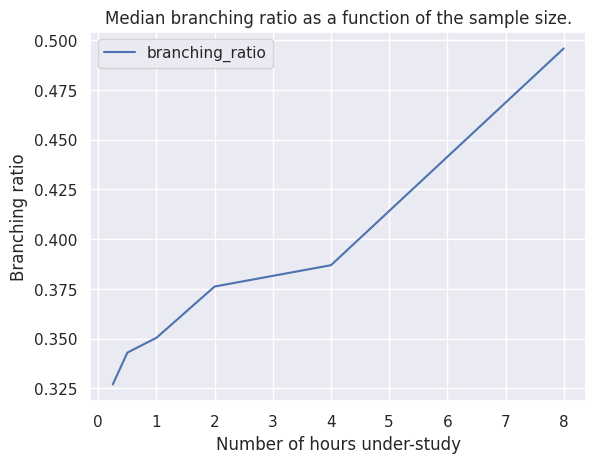

In [39]:
df_parameters_passed.groupby(by = 'num_hours')['branching_ratio'].median().plot(x = 'num_hours', 
                                                                            y = 'branching_ratio', 
                                                                            kind = 'line',
                                                                            title = 'Median branching ratio as a function of the sample size.',
                                                                            grid = True,
                                                                            legend = True,
                                                                            xlabel = 'Number of hours under-study',
                                                                            ylabel = 'Branching ratio',
                                                                            rot = 0,
                                                                            )

### as a function of the kind of baseline

<AxesSubplot: title={'center': 'Median branching ratio as a function of the kind of baseline.'}, xlabel='Kind of baseline class: constant vs piecewise linear', ylabel='Branching ratio'>

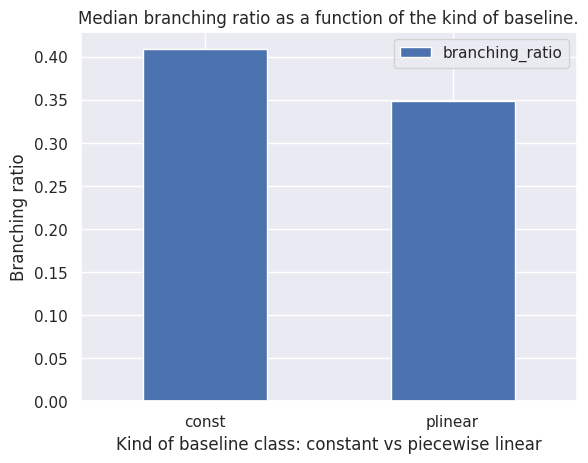

In [40]:
df_parameters_passed.groupby(by = 'baseline_class')['branching_ratio'].median().plot(x = 'baseline_class', 
                                                                                y = 'branching_ratio', 
                                                                                kind = 'bar',
                                                                                title = 'Median branching ratio as a function of the kind of baseline.',
                                                                                grid = True,
                                                                                legend = True,
                                                                                xlabel = 'Kind of baseline class: constant vs piecewise linear',
                                                                                ylabel = 'Branching ratio',
                                                                                rot = 0,
                                                                                )

### as a function of the number of exponential kernels

<AxesSubplot: title={'center': 'Median branching ratio as a function of the number of exponential kernels.'}, xlabel='Number of exponential kernels', ylabel='Branching ratio'>

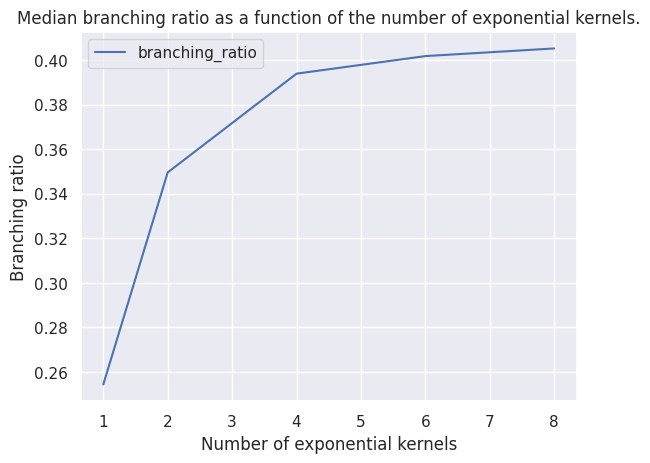

In [41]:
df_parameters_passed.groupby(by = 'num_kernels')['branching_ratio'].median().plot(x = 'num_kernels', 
                                                                            y = 'branching_ratio', 
                                                                            kind = 'line',
                                                                            title = 'Median branching ratio as a function of the number of exponential kernels.',
                                                                            grid = True,
                                                                            legend = True,
                                                                            xlabel = 'Number of exponential kernels',
                                                                            ylabel = 'Branching ratio',
                                                                            rot = 0,
                                                                            )

The more kernels there are, the higher the branching ratio. Which make sense since adding an exonential increases the 'norm' of the kernel.

## 2.5 \ Median number of exponentials for models selected by AIC.

In [23]:
df_parameters_passed = df_parameters_passed.reset_index(drop = True)
df_parameters_passed.head()

,date,baseline_class,num_basis,kernel_class,num_kernels,num_hours,alpha,beta,mu_0,mu_1,...,mu_5,mu_6,mu_7,mu_8,mu_9,ks_stat,p_value,lg_likelihood,aic,branching_ratio
0,2017-01-02,const,10,exp,1,0.25,0.16338587666577448,2.858403120144854,0.025236,0.025236,...,0.025236,0.025236,0.025236,0.025236,0.025236,0.148455,0.565126,-111.132955,228.265910,0.163386
1,2017-01-02,const,10,exp,2,0.25,[0.03788137 0.12550436],[2.85837245 2.85840876],0.025237,0.025237,...,0.025237,0.025237,0.025237,0.025237,0.025237,0.148455,0.565126,-111.132955,228.265910,0.163386
2,2017-01-02,const,10,exp,2,1.00,[0.1514536 0.26283764],[ 1.29763466 37.02346338],0.039401,0.039401,...,0.039401,0.039401,0.039401,0.039401,0.039401,0.087387,0.051182,-603.773683,1213.547365,0.414291
3,2017-01-02,const,10,exp,4,0.25,[0.14176911 0.02115476 0.0457372 0.08243502],[0.06886342 2.98321667 2.98321995 2.98321885],0.021393,0.021393,...,0.021393,0.021393,0.021393,0.021393,0.021393,0.125925,0.758136,-110.575936,227.151871,0.291096
4,2017-01-02,const,10,exp,4,0.50,[0.25614614 0.10059012 0.04602038 0.24571576],[2.38057106e-02 1.44149653e+00 1.44149654e+00 ...,0.026389,0.026389,...,0.026389,0.026389,0.026389,0.026389,0.026389,0.106905,0.104274,-312.397961,630.795922,0.648472


### per sample lenght

In [24]:
df_parameters_passed.groupby(by = 'num_hours')['aic'].idxmin()
idx_best_aic_num_hour = df_parameters_passed.groupby(by = 'num_hours')['aic'].idxmin().to_list()
df_best_aic_per_num_hour = df_parameters_passed.iloc[idx_best_aic_num_hour]
df_best_aic_per_num_hour

,date,baseline_class,num_basis,kernel_class,num_kernels,num_hours,alpha,beta,mu_0,mu_1,...,mu_5,mu_6,mu_7,mu_8,mu_9,ks_stat,p_value,lg_likelihood,aic,branching_ratio
36,2017-01-02,plinear,10,exp,8,0.25,[0.00050935 0.00781958 0.00064383 0.01452793 0...,[19.67944793 19.67944726 2.69291477 2.693211...,0.020287,0.027672,...,0.049050,0.012074,0.037088,0.031383,8.927533e-10,0.146308,0.583370,-108.475733,222.951467,0.159865
37,2017-01-02,plinear,10,exp,8,0.50,[0.01437357 0.02987043 0.04423793 0.04322027 0...,[ 1.21445317 1.21444645 1.21445325 1.214445...,0.028700,0.012248,...,0.108027,0.034804,0.042997,0.043873,7.268644e-02,0.073173,0.487181,-309.617582,625.235165,0.405471
26,2017-01-02,plinear,10,exp,4,1.00,[0.03188894 0.04944143 0.05878366 0.261648 ],[ 1.43675549 1.436754 1.43675448 37.29413141],0.018918,0.021987,...,0.071183,0.033457,0.033426,0.023669,2.457411e-02,0.053414,0.494348,-594.874602,1195.749204,0.401762
39,2017-01-02,plinear,10,exp,8,2.00,[0.00676631 0.00790173 0.00490772 0.02201544 0...,[1.60056130e+00 1.60055896e+00 5.26851832e+01 ...,0.013630,0.041168,...,0.018751,0.016035,0.019576,0.028217,1.039229e-02,0.052717,0.289291,-978.823226,1963.646452,0.419303
34,2017-01-02,plinear,10,exp,6,4.00,[0.05269322 0.08052981 0.01932447 0.03438853 0...,[2.20083293e-01 2.11395276e-02 1.75671237e+00 ...,0.016840,0.053073,...,0.011448,0.020720,0.015420,0.011388,1.432288e-02,0.041962,0.311508,-1630.214029,3266.428058,0.429455
41,2017-01-02,plinear,10,exp,8,8.00,[1.57269637e-02 9.66088116e-02 4.29779924e-04 ...,[1.46996073e+00 1.44455170e-01 5.26959415e+01 ...,0.032397,0.018766,...,0.004226,0.010615,0.014003,0.023479,1.614485e-02,0.028924,0.418353,-2953.749937,5913.499873,0.562553


In [25]:
df_best_aic_per_num_hour['num_kernels'].median()

8.0

It seems the AIC criterion selects models with a high number of exponential kernels (8 here).

### per kind of baseline

In [26]:
df_parameters_passed.groupby(by = 'baseline_class')['aic'].idxmin()
idx_best_aic_baseline_class = df_parameters_passed.groupby(by = 'baseline_class')['aic'].idxmin().to_list()
df_best_aic_per_baseline_class = df_parameters_passed.iloc[idx_best_aic_baseline_class]
df_best_aic_per_baseline_class

,date,baseline_class,num_basis,kernel_class,num_kernels,num_hours,alpha,beta,mu_0,mu_1,...,mu_5,mu_6,mu_7,mu_8,mu_9,ks_stat,p_value,lg_likelihood,aic,branching_ratio
3,2017-01-02,const,10,exp,4,0.25,[0.14176911 0.02115476 0.0457372 0.08243502],[0.06886342 2.98321667 2.98321995 2.98321885],0.021393,0.021393,...,0.021393,0.021393,0.021393,0.021393,2.139272e-02,0.125925,0.758136,-110.575936,227.151871,0.291096
36,2017-01-02,plinear,10,exp,8,0.25,[0.00050935 0.00781958 0.00064383 0.01452793 0...,[19.67944793 19.67944726 2.69291477 2.693211...,0.020287,0.027672,...,0.049050,0.012074,0.037088,0.031383,8.927533e-10,0.146308,0.583370,-108.475733,222.951467,0.159865


In [27]:
df_best_aic_per_num_hour['num_kernels'].median()

8.0

The same goes for the median accross the kinds of baseline, even though it makes less sense here since there are only two baselines that are estimated. Still, several exponential kernels are required to get the right balance between a good fit and a parcimonious model.